# Using Caffe with your own dataset

Reference to 
https://medium.com/machine-learning-world/using-caffe-with-your-own-dataset-b0ade5d71233

A modified version for loading data 
https://gist.github.com/hoching/2d1d16d300f879de6669073a56e39667


In [20]:
caffe_root = '../'  # this file should be run from {caffe_root}/examples (otherwise change this line)

import sys
sys.path.insert(0, caffe_root + 'python')
sys.path.insert(0,'/home/bette/env/local/lib/python3.6/site-packages')
import caffe
import os

import numpy as np
from pylab import *
%matplotlib inline

### copy from caffe example
### Helper function for deprocessing preprocessed images, e.g., for display.
def deprocess_net_image(image):
    image = image.copy()              # don't modify destructively
    image = image[::-1]               # BGR -> RGB
    image = image.transpose(1, 2, 0)  # CHW -> HWC
    image += [123, 117, 104]          # (approximately) undo mean subtraction

    # clamp values in [0, 255]
    image[image < 0], image[image > 255] = 0, 255

    # round and cast from float32 to uint8
    image = np.round(image)
    image = np.require(image, dtype=np.uint8)

    return image

In [2]:
weights = os.path.join(caffe_root, 'models/bvlc_googlenet/bvlc_googlenet.caffemodel')
assert(os.path.exists(weights))

Try to modify the 'lr_multi' term based on different layer type. 

Load prototxt file reference to  https://github.com/BVLC/caffe/issues/4878

In [3]:
from caffe.proto import caffe_pb2
from google.protobuf import text_format

net_param = caffe_pb2.NetParameter()
net_param_file_ori = os.path.join(caffe_root, 'models/bvlc_googlenet/train_val.prototxt')
with open(net_param_file_ori) as f:
    s = f.read()
    text_format.Merge(s, net_param)

In [4]:
layerNames = [l.name for l in net_param.layer]
idx = layerNames.index('conv1/7x7_s2')
#print(net_param.layer[idx])
print(net_param.layer[layerNames.index('loss3/loss3')])

name: "loss3/loss3"
type: "SoftmaxWithLoss"
bottom: "loss3/classifier_dog"
bottom: "label"
top: "loss3/loss3"
loss_weight: 1.0



It seems that Google-net has fully connected layer only at last few layers. 
So here modify only the learning rate at Convolution layers.

GoogleNet Visualization by Netscope
http://ethereon.github.io/netscope/#/gist/6d53c054fba97d038e3da82902d62601

In [5]:
for layer in net_param.layer:
    if layer.type == 'Convolution':
        layer.param[0].lr_mult = 0
        layer.param[1].lr_mult = 0
    elif layer.type == 'InnerProduct':
        layer.param[0].lr_mult = 2
        layer.param[1].lr_mult = 4

Need to modify the fc layer names before apply fine-tuning (not done here).

In [43]:
### save a new prototxt file back with modified learning rate
net_param_file_custom = os.path.join(caffe_root, 'models/bvlc_googlenet/train_val_modi.prototxt')
with open(net_param_file_custom, 'w') as f:
    f.write(str(net_param))

In [8]:
### use command line to do training
#os.chdir(caffe_root)
#!./build/tools/caffe train -solver models/bvlc_googlenet/quick_solver.prototxt \
#-weights models/bvlc_googlenet/bvlc_googlenet.caffemodel

./build/tools/caffe: /home/bette/anaconda3/lib/libtiff.so.5: no version information available (required by /usr/lib/x86_64-linux-gnu/libopencv_highgui.so.2.4)
I0124 19:52:11.283977  4301 caffe.cpp:211] Use CPU.
I0124 19:52:11.284440  4301 solver.cpp:44] Initializing solver from parameters: 
test_iter: 1000
test_interval: 4000
base_lr: 0.01
display: 40
max_iter: 2400000
lr_policy: "poly"
power: 0.5
momentum: 0.9
weight_decay: 0.0002
snapshot: 40000
snapshot_prefix: "models/bvlc_googlenet/bvlc_googlenet_quick"
solver_mode: CPU
net: "models/bvlc_googlenet/train_val_modi.prototxt"
train_state {
  level: 0
  stage: ""
}
test_initialization: false
average_loss: 40
I0124 19:52:11.285609  4301 solver.cpp:87] Creating training net from net file: models/bvlc_googlenet/train_val_modi.prototxt
I0124 19:52:11.286927  4301 net.cpp:294] The NetState phase (0) differed from the phase (1) specified by a rule in layer data
I0124 19:52:11.287027  4301 net.cpp:294] The NetState phase (0) differed from the

    lr_mult: 0
    decay_mult: 0
  }
  convolution_param {
    num_output: 256
    pad: 1
    kernel_size: 3
    weight_filler {
      type: "xavier"
    }
    bias_filler {
      type: "constant"
      value: 0.2
    }
  }
}
layer {
  name: "inception_4c/relu_3x3"
  type: "ReLU"
  bottom: "inception_4c/3x3"
  top: "inception_4c/3x3"
}
layer {
  name: "inception_4c/5x5_reduce"
  type: "Convolution"
  bottom: "inception_4b/output"
  top: "inception_4c/5x5_reduce"
  param {
    lr_mult: 0
    decay_mult: 1
  }
  param {
    lr_mult: 0
    decay_mult: 0
  }
  convolution_param {
    num_output: 24
    kernel_size: 1
    weight_filler {
      type: "xavier"
    }
    bias_filler {
      type: "constant"
      value: 0.2
    }
  }
}
layer {
  name: "inception_4c/relu_5x5_reduce"
  type: "ReLU"
  bottom: "inception_4c/5x5_reduce"
  top: "inception_4c/5x5_reduce"
}
layer {
  name: "inception_4c/5x5"
  type: "Convolution"
  bottom: "inception_4c/5x5_reduce"
  top: "inception_4c/5x5"
  param {


I0124 19:52:11.376173  4301 net.cpp:84] Creating Layer data
I0124 19:52:11.376231  4301 net.cpp:380] data -> data
I0124 19:52:11.376286  4301 net.cpp:380] data -> label
I0124 19:52:11.378657  4301 data_layer.cpp:45] output data size: 32,3,224,224
I0124 19:52:11.378794  4301 net.cpp:122] Setting up data
I0124 19:52:11.378829  4301 net.cpp:129] Top shape: 32 3 224 224 (4816896)
I0124 19:52:11.378854  4301 net.cpp:129] Top shape: 32 (32)
I0124 19:52:11.378875  4301 net.cpp:137] Memory required for data: 19267712
I0124 19:52:11.378886  4301 layer_factory.hpp:77] Creating layer label_data_1_split
I0124 19:52:11.378901  4301 net.cpp:84] Creating Layer label_data_1_split
I0124 19:52:11.378908  4301 net.cpp:406] label_data_1_split <- label
I0124 19:52:11.378960  4301 net.cpp:380] label_data_1_split -> label_data_1_split_0
I0124 19:52:11.378973  4301 net.cpp:380] label_data_1_split -> label_data_1_split_1
I0124 19:52:11.378983  4301 net.cpp:380] label_data_1_split -> label_data_1_split_2
I0124 

I0124 19:52:11.395402  4301 layer_factory.hpp:77] Creating layer inception_3b/pool_proj
I0124 19:52:11.395470  4301 net.cpp:84] Creating Layer inception_3b/pool_proj
I0124 19:52:11.395483  4301 net.cpp:406] inception_3b/pool_proj <- inception_3b/pool
I0124 19:52:11.395496  4301 net.cpp:380] inception_3b/pool_proj -> inception_3b/pool_proj
I0124 19:52:11.395715  4301 net.cpp:122] Setting up inception_3b/pool_proj
I0124 19:52:11.395751  4301 net.cpp:129] Top shape: 32 64 28 28 (1605632)
I0124 19:52:11.395761  4301 net.cpp:137] Memory required for data: 1024393728
I0124 19:52:11.395792  4301 layer_factory.hpp:77] Creating layer inception_3b/relu_pool_proj
I0124 19:52:11.395809  4301 net.cpp:84] Creating Layer inception_3b/relu_pool_proj
I0124 19:52:11.395820  4301 net.cpp:406] inception_3b/relu_pool_proj <- inception_3b/pool_proj
I0124 19:52:11.395833  4301 net.cpp:367] inception_3b/relu_pool_proj -> inception_3b/pool_proj (in-place)
I0124 19:52:11.395846  4301 net.cpp:122] Setting up inc

I0124 19:52:11.448168  4301 net.cpp:367] inception_4c/relu_pool_proj -> inception_4c/pool_proj (in-place)
I0124 19:52:11.448200  4301 net.cpp:122] Setting up inception_4c/relu_pool_proj
I0124 19:52:11.448210  4301 net.cpp:129] Top shape: 32 64 14 14 (401408)
I0124 19:52:11.448223  4301 net.cpp:137] Memory required for data: 1417346564
I0124 19:52:11.448230  4301 layer_factory.hpp:77] Creating layer inception_4c/output
I0124 19:52:11.448246  4301 net.cpp:84] Creating Layer inception_4c/output
I0124 19:52:11.448253  4301 net.cpp:406] inception_4c/output <- inception_4c/1x1
I0124 19:52:11.448287  4301 net.cpp:406] inception_4c/output <- inception_4c/3x3
I0124 19:52:11.448295  4301 net.cpp:406] inception_4c/output <- inception_4c/5x5
I0124 19:52:11.448309  4301 net.cpp:406] inception_4c/output <- inception_4c/pool_proj
I0124 19:52:11.448529  4301 net.cpp:380] inception_4c/output -> inception_4c/output
I0124 19:52:11.448559  4301 net.cpp:122] Setting up inception_4c/output
I0124 19:52:11.44

I0124 19:52:11.496958  4301 net.cpp:406] loss2/relu_fc <- loss2/fc
I0124 19:52:11.499172  4301 net.cpp:367] loss2/relu_fc -> loss2/fc (in-place)
I0124 19:52:11.499191  4301 net.cpp:122] Setting up loss2/relu_fc
I0124 19:52:11.499203  4301 net.cpp:129] Top shape: 32 1024 (32768)
I0124 19:52:11.499209  4301 net.cpp:137] Memory required for data: 1611087364
I0124 19:52:11.499217  4301 layer_factory.hpp:77] Creating layer loss2/drop_fc
I0124 19:52:11.499228  4301 net.cpp:84] Creating Layer loss2/drop_fc
I0124 19:52:11.499234  4301 net.cpp:406] loss2/drop_fc <- loss2/fc
I0124 19:52:11.499243  4301 net.cpp:367] loss2/drop_fc -> loss2/fc (in-place)
I0124 19:52:11.499253  4301 net.cpp:122] Setting up loss2/drop_fc
I0124 19:52:11.499260  4301 net.cpp:129] Top shape: 32 1024 (32768)
I0124 19:52:11.499266  4301 net.cpp:137] Memory required for data: 1611218436
I0124 19:52:11.499272  4301 layer_factory.hpp:77] Creating layer loss2/classifier_dog
I0124 19:52:11.499282  4301 net.cpp:84] Creating Lay

I0124 19:52:11.552665  4301 layer_factory.hpp:77] Creating layer inception_5b/relu_5x5
I0124 19:52:11.552685  4301 net.cpp:84] Creating Layer inception_5b/relu_5x5
I0124 19:52:11.552698  4301 net.cpp:406] inception_5b/relu_5x5 <- inception_5b/5x5
I0124 19:52:11.552717  4301 net.cpp:367] inception_5b/relu_5x5 -> inception_5b/5x5 (in-place)
I0124 19:52:11.552736  4301 net.cpp:122] Setting up inception_5b/relu_5x5
I0124 19:52:11.552747  4301 net.cpp:129] Top shape: 32 128 7 7 (200704)
I0124 19:52:11.552755  4301 net.cpp:137] Memory required for data: 1781230088
I0124 19:52:11.552764  4301 layer_factory.hpp:77] Creating layer inception_5b/pool
I0124 19:52:11.552778  4301 net.cpp:84] Creating Layer inception_5b/pool
I0124 19:52:11.552790  4301 net.cpp:406] inception_5b/pool <- inception_5a/output_inception_5a/output_0_split_3
I0124 19:52:11.552805  4301 net.cpp:380] inception_5b/pool -> inception_5b/pool
I0124 19:52:11.552826  4301 net.cpp:122] Setting up inception_5b/pool
I0124 19:52:11.55

I0124 19:52:11.603781  4301 net.cpp:380] inception_4a/output_inception_4a/output_0_split -> inception_4a/output_inception_4a/output_0_split_2
I0124 19:52:11.603796  4301 net.cpp:380] inception_4a/output_inception_4a/output_0_split -> inception_4a/output_inception_4a/output_0_split_3
I0124 19:52:11.603808  4301 net.cpp:380] inception_4a/output_inception_4a/output_0_split -> inception_4a/output_inception_4a/output_0_split_4
I0124 19:52:11.603823  4301 net.cpp:122] Setting up inception_4a/output_inception_4a/output_0_split
I0124 19:52:11.603835  4301 net.cpp:129] Top shape: 50 512 14 14 (5017600)
I0124 19:52:11.603847  4301 net.cpp:129] Top shape: 50 512 14 14 (5017600)
I0124 19:52:11.603857  4301 net.cpp:129] Top shape: 50 512 14 14 (5017600)
I0124 19:52:11.603868  4301 net.cpp:129] Top shape: 50 512 14 14 (5017600)
I0124 19:52:11.603879  4301 net.cpp:129] Top shape: 50 512 14 14 (5017600)
I0124 19:52:11.603889  4301 net.cpp:137] Memory required for data: 1968155600
I0124 19:52:11.603899

I0124 19:52:11.651376  4301 net.cpp:84] Creating Layer inception_4b/relu_1x1
I0124 19:52:11.651386  4301 net.cpp:406] inception_4b/relu_1x1 <- inception_4b/1x1
I0124 19:52:11.651399  4301 net.cpp:367] inception_4b/relu_1x1 -> inception_4b/1x1 (in-place)
I0124 19:52:11.651419  4301 net.cpp:122] Setting up inception_4b/relu_1x1
I0124 19:52:11.651432  4301 net.cpp:129] Top shape: 50 160 14 14 (1568000)
I0124 19:52:11.651440  4301 net.cpp:137] Memory required for data: 1983867612
I0124 19:52:11.651449  4301 layer_factory.hpp:77] Creating layer inception_4b/3x3_reduce
I0124 19:52:11.651461  4301 net.cpp:84] Creating Layer inception_4b/3x3_reduce
I0124 19:52:11.651474  4301 net.cpp:406] inception_4b/3x3_reduce <- inception_4a/output_inception_4a/output_0_split_2
I0124 19:52:11.651486  4301 net.cpp:380] inception_4b/3x3_reduce -> inception_4b/3x3_reduce
I0124 19:52:11.651926  4301 net.cpp:122] Setting up inception_4b/3x3_reduce
I0124 19:52:11.651939  4301 net.cpp:129] Top shape: 50 112 14 14 

I0124 19:52:11.714390  4301 net.cpp:122] Setting up inception_5a/1x1
I0124 19:52:11.714464  4301 net.cpp:129] Top shape: 50 256 7 7 (627200)
I0124 19:52:11.714475  4301 net.cpp:137] Memory required for data: 2694568424
I0124 19:52:11.714493  4301 layer_factory.hpp:77] Creating layer inception_5a/relu_1x1
I0124 19:52:11.714510  4301 net.cpp:84] Creating Layer inception_5a/relu_1x1
I0124 19:52:11.714524  4301 net.cpp:406] inception_5a/relu_1x1 <- inception_5a/1x1
I0124 19:52:11.714540  4301 net.cpp:367] inception_5a/relu_1x1 -> inception_5a/1x1 (in-place)
I0124 19:52:11.714555  4301 net.cpp:122] Setting up inception_5a/relu_1x1
I0124 19:52:11.714567  4301 net.cpp:129] Top shape: 50 256 7 7 (627200)
I0124 19:52:11.714577  4301 net.cpp:137] Memory required for data: 2697077224
I0124 19:52:11.714587  4301 layer_factory.hpp:77] Creating layer inception_5a/3x3_reduce
I0124 19:52:11.714602  4301 net.cpp:84] Creating Layer inception_5a/3x3_reduce
I0124 19:52:11.714617  4301 net.cpp:406] incepti

I0124 19:52:11.768589  4301 net.cpp:122] Setting up inception_5b/5x5
I0124 19:52:11.768649  4301 net.cpp:129] Top shape: 50 128 7 7 (313600)
I0124 19:52:11.768688  4301 net.cpp:137] Memory required for data: 2782062824
I0124 19:52:11.768703  4301 layer_factory.hpp:77] Creating layer inception_5b/relu_5x5
I0124 19:52:11.768725  4301 net.cpp:84] Creating Layer inception_5b/relu_5x5
I0124 19:52:11.768743  4301 net.cpp:406] inception_5b/relu_5x5 <- inception_5b/5x5
I0124 19:52:11.768775  4301 net.cpp:367] inception_5b/relu_5x5 -> inception_5b/5x5 (in-place)
I0124 19:52:11.768797  4301 net.cpp:122] Setting up inception_5b/relu_5x5
I0124 19:52:11.768831  4301 net.cpp:129] Top shape: 50 128 7 7 (313600)
I0124 19:52:11.768838  4301 net.cpp:137] Memory required for data: 2783317224
I0124 19:52:11.768853  4301 layer_factory.hpp:77] Creating layer inception_5b/pool
I0124 19:52:11.768862  4301 net.cpp:84] Creating Layer inception_5b/pool
I0124 19:52:11.768877  4301 net.cpp:406] inception_5b/pool <

I0124 19:52:11.866797  4301 upgrade_proto.cpp:53] Attempting to upgrade input file specified using deprecated V1LayerParameter: models/bvlc_googlenet/bvlc_googlenet.caffemodel
I0124 19:52:11.946795  4301 upgrade_proto.cpp:61] Successfully upgraded file specified using deprecated V1LayerParameter
I0124 19:52:11.951249  4301 net.cpp:744] Ignoring source layer loss1/classifier
I0124 19:52:11.953850  4301 net.cpp:744] Ignoring source layer loss2/classifier
I0124 19:52:11.956167  4301 net.cpp:744] Ignoring source layer loss3/classifier
I0124 19:52:12.006141  4301 upgrade_proto.cpp:53] Attempting to upgrade input file specified using deprecated V1LayerParameter: models/bvlc_googlenet/bvlc_googlenet.caffemodel
I0124 19:52:12.062070  4301 upgrade_proto.cpp:61] Successfully upgraded file specified using deprecated V1LayerParameter
I0124 19:52:12.065851  4301 net.cpp:744] Ignoring source layer loss1/classifier
I0124 19:52:12.068838  4301 net.cpp:744] Ignoring source layer loss2/classifier
I0124 

I0125 00:11:05.482646  4304 data_layer.cpp:73] Restarting data prefetching from start.
I0125 00:19:38.698925  4301 solver.cpp:218] Iteration 560 (0.0351053 iter/s, 1139.43s/40 iters), loss = 5.43584
I0125 00:19:38.699041  4301 solver.cpp:237]     Train net output #0: loss1/loss1 = 4.26917 (* 0.3 = 1.28075 loss)
I0125 00:19:38.699054  4301 solver.cpp:237]     Train net output #1: loss2/loss2 = 4.69999 (* 0.3 = 1.41 loss)
I0125 00:19:38.699062  4301 solver.cpp:237]     Train net output #2: loss3/loss3 = 0.822869 (* 1 = 0.822869 loss)
I0125 00:19:38.699072  4301 sgd_solver.cpp:105] Iteration 560, lr = 0.00999883
I0125 00:38:39.505446  4301 solver.cpp:218] Iteration 600 (0.0350629 iter/s, 1140.81s/40 iters), loss = 5.39993
I0125 00:38:39.505520  4301 solver.cpp:237]     Train net output #0: loss1/loss1 = 5.11833 (* 0.3 = 1.5355 loss)
I0125 00:38:39.505532  4301 solver.cpp:237]     Train net output #1: loss2/loss2 = 4.22903 (* 0.3 = 1.26871 loss)
I0125 00:38:39.505540  4301 solver.cpp:237] 

I0125 05:24:11.825644  4301 solver.cpp:218] Iteration 1200 (0.035 iter/s, 1142.86s/40 iters), loss = 5.15605
I0125 05:24:11.825721  4301 solver.cpp:237]     Train net output #0: loss1/loss1 = 4.84822 (* 0.3 = 1.45447 loss)
I0125 05:24:11.825731  4301 solver.cpp:237]     Train net output #1: loss2/loss2 = 4.64672 (* 0.3 = 1.39402 loss)
I0125 05:24:11.825740  4301 solver.cpp:237]     Train net output #2: loss3/loss3 = 2.84035 (* 1 = 2.84035 loss)
I0125 05:24:11.825752  4301 sgd_solver.cpp:105] Iteration 1200, lr = 0.0099975
I0125 05:43:14.569481  4301 solver.cpp:218] Iteration 1240 (0.0350035 iter/s, 1142.74s/40 iters), loss = 5.35479
I0125 05:43:14.569558  4301 solver.cpp:237]     Train net output #0: loss1/loss1 = 4.60526 (* 0.3 = 1.38158 loss)
I0125 05:43:14.569569  4301 solver.cpp:237]     Train net output #1: loss2/loss2 = 4.74279 (* 0.3 = 1.42284 loss)
I0125 05:43:14.569577  4301 solver.cpp:237]     Train net output #2: loss3/loss3 = 2.20886 (* 1 = 2.20886 loss)
I0125 05:43:14.5695

In [17]:
### load the weights after training
#os.chdir('examples')
weights_fine = os.path.join(caffe_root, 'models/bvlc_googlenet/bvlc_googlenet_quick_iter_1973.caffemodel')

net_fine = caffe.Net(net_param_file_custom, weights_fine, caffe.TEST)
net_fine.forward()

n02102480-Sussex_spaniel


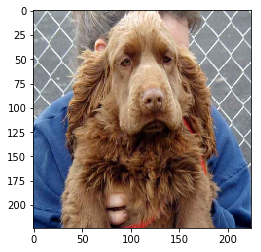

In [46]:
### print out input image and check the prediction result
demo_index = 22
demo_img = net_fine.blobs['data'].data[demo_index,:]
plt.imshow(deprocess_net_image(demo_img))

probs = net_fine.blobs['loss3/classifier_dog']

label_file = 'dogs/label.txt'
labels = list(np.loadtxt(label_file, str, delimiter='\n'))
print(labels[probs.data[demo_index].argmax()])

# Use weights trained by ImageNet for demostration

In [33]:
### debug: dead kernel may be insufficient permissions on data directory
net_param_file_deploy = os.path.join(caffe_root, 'models/bvlc_googlenet/deploy.prototxt')
net = caffe.Net(net_param_file_deploy, weights, caffe.TEST)

### Load ImageNet labels to imagenet_labels
imagenet_label_file = caffe_root + 'data/ilsvrc12/synset_words.txt'
imagenet_labels = list(np.loadtxt(imagenet_label_file, str, delimiter='\t'))
assert len(imagenet_labels) == 1000

# print(net.blobs)
# for k, v in net.blobs.items():
#     print(k, v.data.shape)

Prepare input data.

[104.00698793 116.66876762 122.67891434]
mean-subtracted values: <zip object at 0x7f9cbd0bbd88>


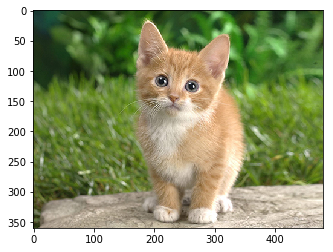

In [34]:
### load the mean ImageNet image (as distributed with Caffe) for subtraction
### (npy format: https://github.com/numpy/numpy/blob/master/doc/neps/npy-format.rst)
mu = np.load(caffe_root + 'python/caffe/imagenet/ilsvrc_2012_mean.npy')

mu = mu.mean(1).mean(1)  # average over pixels to obtain the mean (BGR) pixel values
print(mu)
print ('mean-subtracted values:', zip('BGR', mu))

### create transformer for the input called 'data'
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})

transformer.set_transpose('data', (2,0,1))  # move image channels to outermost dimension
transformer.set_mean('data', mu)            # subtract the dataset-mean value in each channel
transformer.set_raw_scale('data', 255)      # rescale from [0, 1] to [0, 255]
transformer.set_channel_swap('data', (2,1,0))  # swap channels from RGB to BGR

image = caffe.io.load_image(caffe_root + 'examples/images/cat.jpg')

net.blobs['data'].reshape(50,        # batch size
                          3,         # 3-channel (BGR) images
                          224, 224)  # image size is 224x224

transformed_image = transformer.preprocess('data', image)
plt.imshow(image)

In [35]:
net.blobs['data'].data[...] = transformed_image
out = net.forward()

In [36]:
pred_index = out['prob'][0]
print(imagenet_labels[pred_index.argmax()])

pred_index_tops = pred_index.argsort()[::-1][:5]

for i in pred_index_tops:
    print(pred_index[i], imagenet_labels[i])

n02123159 tiger cat
0.5017325 n02123159 tiger cat
0.22782555 n02123045 tabby, tabby cat
0.16218388 n02124075 Egyptian cat
0.027825171 n02127052 lynx, catamount
0.013288776 n02123394 Persian cat
